## Introduction

This step focuses on collecting the data, organizing it, and making sure it's well defined. 

The data comes from a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
* `toxic`
* `severe_toxic`
* `obscene`
* `threat`
* `insult`
* `identity_hate`

### Objective

Create a model which predicts a probability of each type of toxicity for each comment.

### Import Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import matplotlib as mpl

mpl.style.use("seaborn")
# mpl.rcParams["figure.dpi"] = 100

### Data Collection

Goal: Organize data to streamline the next steps.

In [2]:
raw_train_data = pd.read_csv("../data/train.csv")
raw_train_data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
67977,b5db69dcbe54df49,Thanks for taking the time to inform me of the...,0,0,0,0,0,0
116744,701794650c6273aa,Bogaert is used as a reference for different p...,0,0,0,0,0,0
62064,a60b6a4c70b19be9,"The Electrolux Timeline at states Kelvinator,...",0,0,0,0,0,0
130196,b889d0235cc46712,"The truth is difficult sometimes, best to acce...",0,0,0,0,0,0
102808,2625e751c827b607,Suck my cheesy dick ),1,1,1,0,1,0


### Data Definition

Goal: Gain an understanding of the data features

In [3]:
# Here is an example of a comment
example_comment = raw_train_data['comment_text'][random.randint(0, raw_train_data.shape[0])]
print(example_comment)

Biodiesel Systems spam 

You mentioned that the link was only posted once when reverting my edit. If you examine the [user's record|http://en.wikipedia.org/wiki/Special:Contributions/79.78.181.59], the spam I reverted was added to numerous pages related to biodiesel.  The user in question has added numerous refspam links, even after warning and conversation elaborating on why the references were inappropriate.  See WP:REFSPAM.


Identify column names that will be used for prediction

In [4]:
# Create a list of labels to predict
labels_to_predict = list(raw_train_data.columns[2:])
print(labels_to_predict)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Explore what are the data types for each column of the dataset

In [5]:
# call info to see a summary of the data
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Only the column`comment_text`is not numerical, the rest of columns are integers. We will have to change from integers to floats to predict the probability of each type.

In [6]:
comments_len = raw_train_data['comment_text'].str.len()

Unique values for each column

In [7]:
for label in labels_to_predict:
    print(raw_train_data[label].value_counts())
    print("\n")

0    144277
1     15294
Name: toxic, dtype: int64


0    157976
1      1595
Name: severe_toxic, dtype: int64


0    151122
1      8449
Name: obscene, dtype: int64


0    159093
1       478
Name: threat, dtype: int64


0    151694
1      7877
Name: insult, dtype: int64


0    158166
1      1405
Name: identity_hate, dtype: int64




### Summary Statistics

Visualize the distribution of characters on each comment.

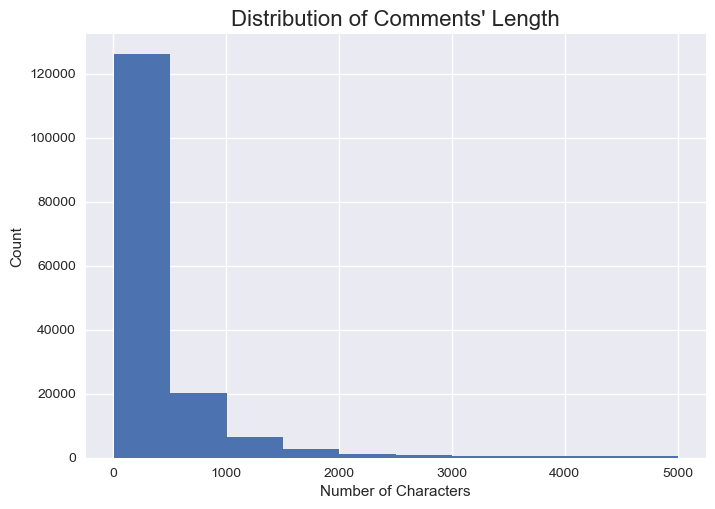

In [8]:
plt.hist(comments_len)
plt.title("Distribution of Comments' Length", fontsize=16)
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()

Descriptive statistics of the comments' length

In [9]:
print(comments_len.describe())

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64


We can see that most of the comments have between `0 - 1000` characters. These include characters that are not letters.

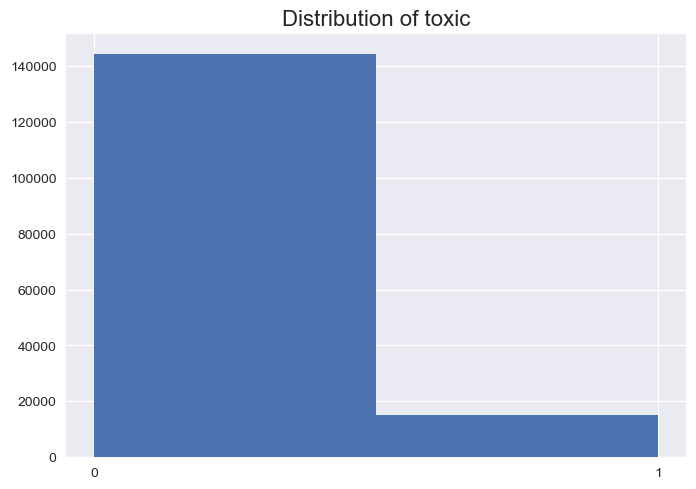

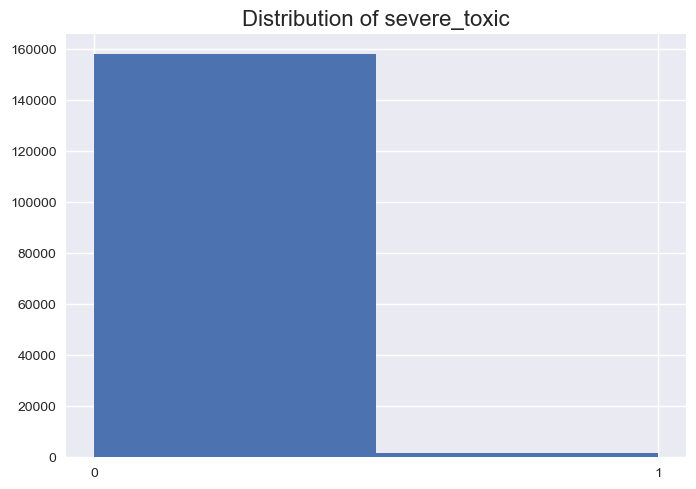

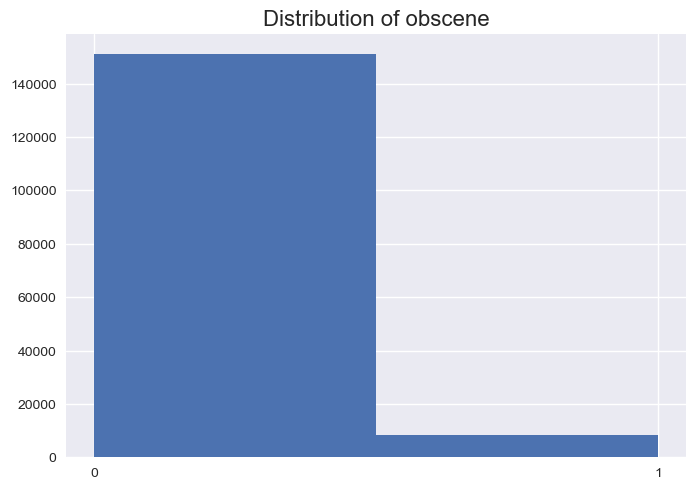

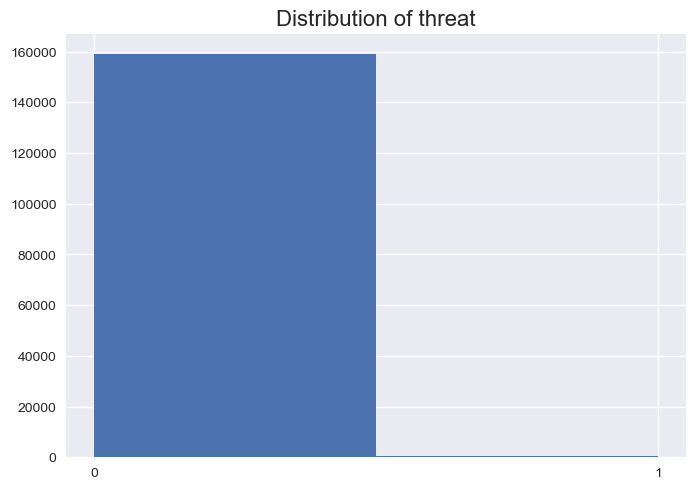

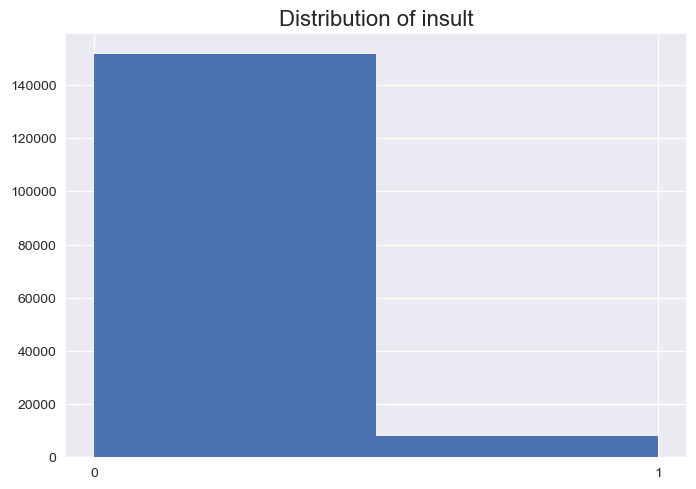

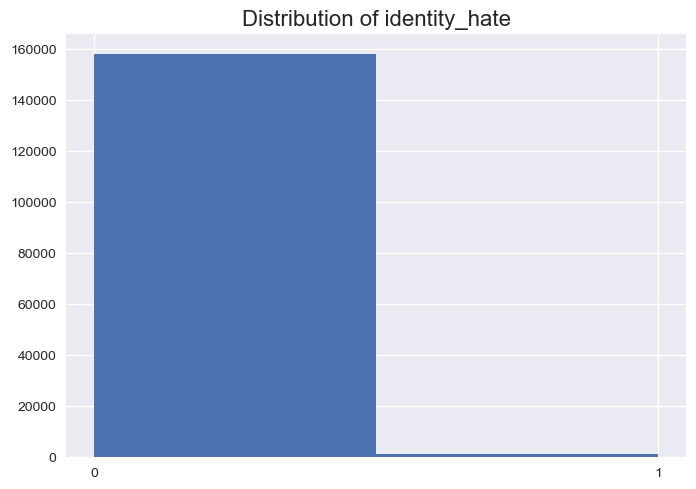

In [10]:
def plot_distributions(label):
    plt.clf()
    plt.hist(raw_train_data[label], bins=2)
    plt.title("Distribution of {}".format(label), fontsize=16)
    plt.xticks([0, 1])
    plt.show()
    
for label in labels_to_predict:
    plot_distributions(label)


We can see that the majority or comments are not toxic.

### Data Cleaning

Check for any null or missing values

In [11]:
raw_train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We can see that this dataset does not contain missing values.

In [12]:
raw_train_data.duplicated().sum()

0

This dataset does not contain any duplicate rows.

Clean comments of unnecessaty symbols

In [13]:
example_comment

"Biodiesel Systems spam \n\nYou mentioned that the link was only posted once when reverting my edit. If you examine the [user's record|http://en.wikipedia.org/wiki/Special:Contributions/79.78.181.59], the spam I reverted was added to numerous pages related to biodiesel.  The user in question has added numerous refspam links, even after warning and conversation elaborating on why the references were inappropriate.  See WP:REFSPAM."

In [14]:
example_comment.split()

['Biodiesel',
 'Systems',
 'spam',
 'You',
 'mentioned',
 'that',
 'the',
 'link',
 'was',
 'only',
 'posted',
 'once',
 'when',
 'reverting',
 'my',
 'edit.',
 'If',
 'you',
 'examine',
 'the',
 "[user's",
 'record|http://en.wikipedia.org/wiki/Special:Contributions/79.78.181.59],',
 'the',
 'spam',
 'I',
 'reverted',
 'was',
 'added',
 'to',
 'numerous',
 'pages',
 'related',
 'to',
 'biodiesel.',
 'The',
 'user',
 'in',
 'question',
 'has',
 'added',
 'numerous',
 'refspam',
 'links,',
 'even',
 'after',
 'warning',
 'and',
 'conversation',
 'elaborating',
 'on',
 'why',
 'the',
 'references',
 'were',
 'inappropriate.',
 'See',
 'WP:REFSPAM.']